# De-biasing standard deviation estimators

This post describes how to adjust traditional standard deviation (SD) estimators to reduce their bias. The SD is simply the square root of the variance, usually denoted $\sigma$ and $\sigma^2$, respectively. These two terms are [population parameters](https://en.wikipedia.org/wiki/Statistical_parameter). While the well-known sample variance estimator provides an unbiased estimate of its population parameter, the equivalent sample SD estimator does not. The reason for this difference is due to [Jensen's iequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality), which is why unbiased statistical estimators are not (in general) invariant to concave or convex transformations. For Gaussian data, the bias of the sample SD can be characterized analytically and offset with an appropriate term. In the non-Gaussian case, the magnitude of the bias can be expressed as an infinite series, and thus is amenable to approximations up to $O(n^{2.5})$. Although in practice, these higher order offset terms are too noisy and thus a first-order approximation is (potentially) the best solution, which converges at a rate of $O(n^{1.5})$. 

Describing and mitigating the bias in estimating the SD is not a new topic, and this post draws heavily on Dr. Dave Giles blog post [Unbiased Estimation of a Standard Deviation](https://davegiles.blogspot.com/2013/12/unbiased-estimation-of-standard.html) and this working paper [Giles (2021)](http://web.uvic.ca/~dgiles/downloads/working_papers/std_dev.pdf). I've tried to make it clear in following sections the source of the derivations.

The rest of this post is structured into four sections:

1. Describe the cause of the traditional SD estimator bias and provide empirical evidence from an exponential distribution (recap).
2. Derive the exact offset for the Gaussian and approximations for the non-Gaussian data (recap), and show how effective a higher-order oracle offset is (original).
3. Demonstrate empirical results for bias-variance trade-off for different de-biasing strategies (original).
4. Show how these techniques can be used in an applied regression setting (original).

This post was generated from an original notebook that can be found HERE. For readability, various code blocks have been supressed and the text has been tidied up.

<br>



## (1) Background

It is well understood that the [sample variance](https://en.wikipedia.org/wiki/Variance#Unbiased_sample_variance), denoted throughout as $S^2$, is an unbiased estimate of the variance for any well-behaved continuous distribution.

<br>

$$
\begin{align*}
X &\sim F \hspace{2mm} \text{where $F$ is some continuous dist} \\
\text{Var}(X) &= \sigma^2 = E([X - E(X)]^2) \\
S^2 &= (n-1)^{-1} \sum_{i=1}^n (X_i - \bar{X})^2 \\ 
\bar{X} &= n^{-1} \sum_{i=1}^n X_i \\
(n-1) E[S^2] &= \sum_{i=1}^n E[(X_i - \mu)^2] - nE[(\bar{X} - \mu)^2] \\
&= \sum_{i=1}^n \sigma^2 - n \text{Var}(\bar{X}) \\
&= n\sigma^2 - n \frac{\sigma^2}{n} \\
&= (n-1) \sigma^2 \hspace{2mm} \longleftrightarrow \\
E[S^2] &= \sigma^2
\end{align*}
$$


This fact is pretty remarkable. For any finite sample of data, and using [Bessel's correction](https://en.wikipedia.org/wiki/Bessel%27s_correction), we can obtain an unbiased estimate of the second moment of any continuous distribution. Of course, the sampling variance of the estimator $S^2$ will be inversely proportional to the sample size, but a standard error can be estimated using the traditional non-parametric approaches like the bootstrap to obtain approximate coverage for hypothesis testing.[[^1]] While $S^2$ is an unbiased estimate of the population variance, will $S$ be an unbiased estimate of the population standard deviation?

The short answer is no: an unbiased estimator is generally not invariant under parameter transformations. Why is this the case? It's because of [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality#Probabilistic_form): the function of an expectation of a random variable, will not (in general) be equal to the expectation of a function of a random variable. 

$$
\begin{align*}
\text{SD}(X) &= \sqrt{\text{Var}(X)} \\
&= \sqrt{E([X - E(X)]^2)} = \sqrt{\sigma^2} = \sigma \\
E[S^2] &=  (n-1)^{-1} \sum_{i=1}^n E(X_i - \bar{X})^2 = \sigma^2 \\
E[S] &= E\Bigg\{ \frac{1}{n-1} \sum_{i=1}^n (X_i - \bar{X})^2 \Bigg\}^{0.5} \\
&\neq \sigma \hspace{2mm} \text{ by Jensen's inequality}
\end{align*}
$$

In this instance, $S^2$ is the random variable, and the function is a square root transformation. In fact, Jensen's inequality tells us that:

$$
\begin{align*}
E[f(S^2)] &\leq f(E[S^2]) \\
E[S] &\leq \sigma
\end{align*}
$$

When $f(\cdot)$ is a [concave function](https://en.wikipedia.org/wiki/Concave_function), which the square-root transformation is. In other words, taking the square root of the sample variance (i.e. the sample standard deviation) will lead to an under-estimate of the true population standard deviation. However, it's important to note that $S$ is still a consistent estimator of $\sigma$ because $\text{Var}(S^2) \to 0$ as $n \to \infty$ so $S \overset{p}{\to} \sigma$. In other words, while $S$ is biased, it is still consistent. The simulation example below shows both the bias and consistency of $S$ visually.

### (1.1) Simulation showing bias

Consider a simple single-parameter [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution), $X \sim \text{Exp}(\lambda)$ where $\lambda$ is the rate parameter. The moments of the exponential distribution are well defined: $E[X]=\lambda^{-1}$, $E[(X-\lambda^{-1})^2]=\lambda^{-2}$, and so on. The simulation below will consider three different values of $\lambda = \{1/2, 1, 2\}$, and 7 different finite sample sizes: $n=\{2^1, 2^2, \dots, 2^7\}$, and compare the oracle variance and standard deviation to their empirical counterparts.

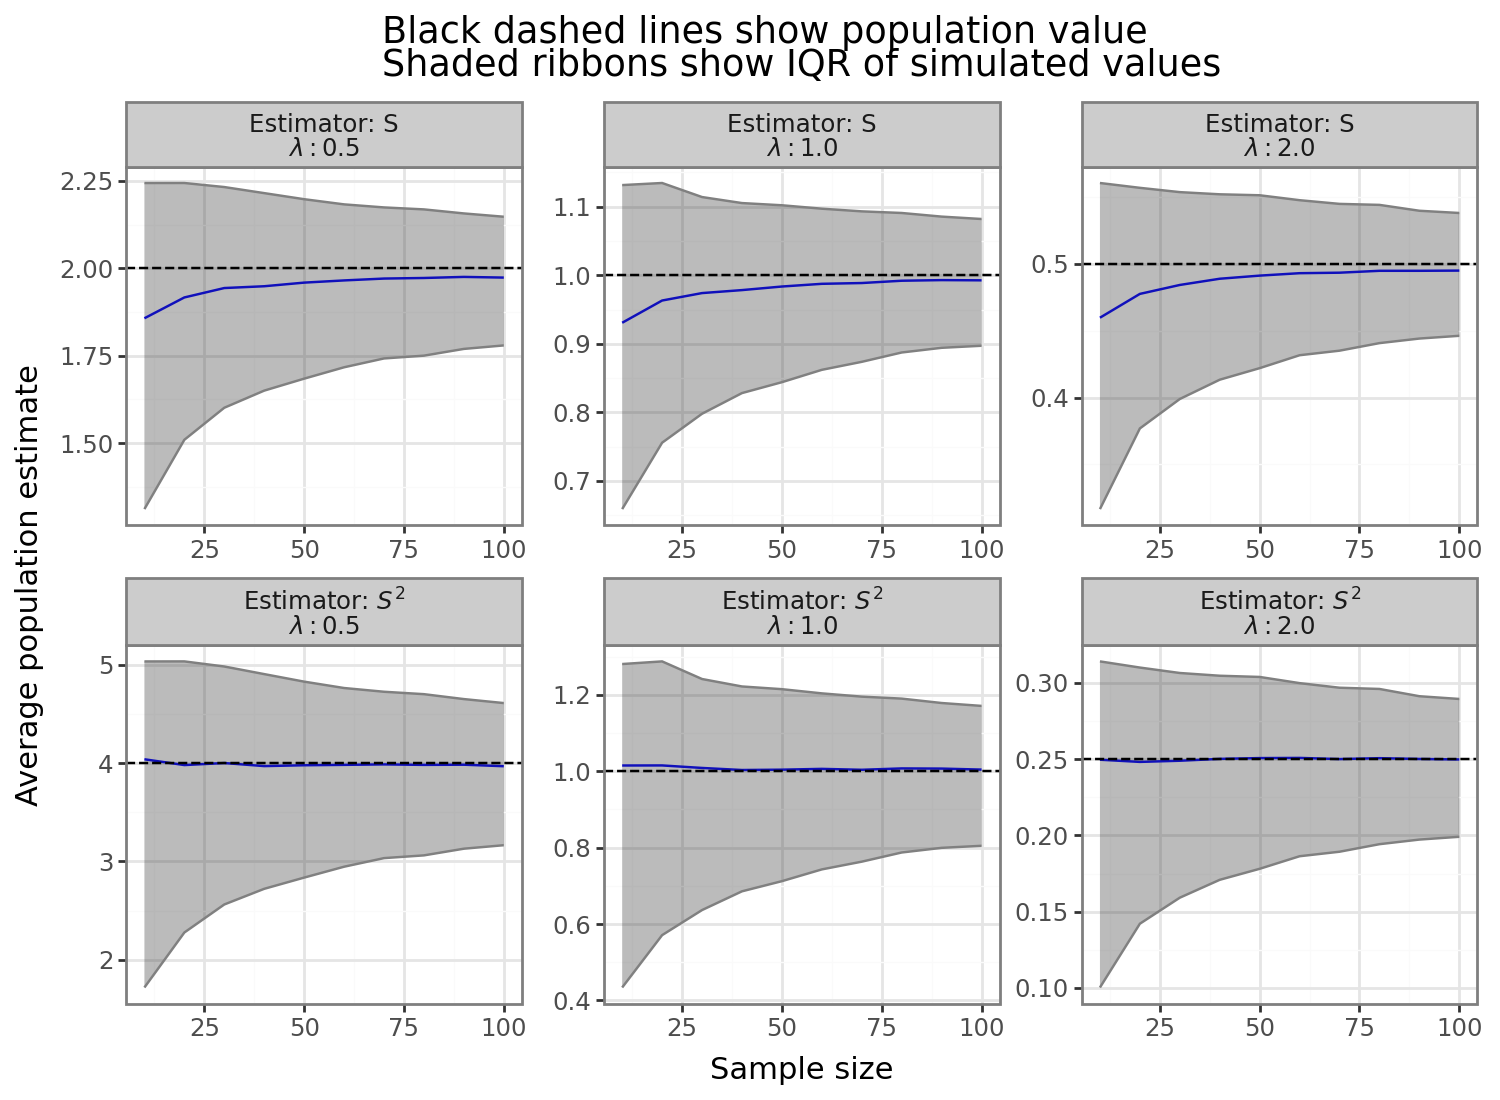

In [1]:
# Import modules to be used throughout post
import numpy as np
import pandas as pd
import plotnine as pn
from scipy.stats import norm, expon
from utils import calculate_summary_stats

nsim = 2500  # Number of simluations
sample_sizes = np.arange(10, 100+1, 10).astype(int)
n_sample_sizes = len(sample_sizes)
rates = np.array([1/2, 1, 2])
n_rates = len(rates)
dist_expon = expon(scale = 1 / rates)
oracle_variance = dist_expon.var()
oracle_sd = np.sqrt(oracle_variance)
# Run the simulation
holder_var = np.zeros((nsim, n_sample_sizes, n_rates))
for i in range(nsim):
    sim_var_i = np.vstack([dist_expon.rvs(size=(n, n_rates), random_state=i+1).var(ddof=1, axis=0) for n in sample_sizes])
    holder_var[i] = sim_var_i
# Calculate average results with some variation
res_var = calculate_summary_stats(holder_var, colnames=rates, idxnames=sample_sizes, var_name='rate', value_name='n')
res_sd = calculate_summary_stats(np.sqrt(holder_var), colnames=rates, idxnames=sample_sizes, var_name='rate', value_name='n')

# Calculate the oracle quantities
dat_oracle_expon = pd.concat(objs = [pd.DataFrame({'msr':'Var', 'rate':rates, 'oracle':oracle_variance}),
                                     pd.DataFrame({'msr':'SD', 'rate':rates, 'oracle':oracle_sd})])
# Merge results
res_expon = pd.concat(objs = [res_var.assign(msr='Var'), res_sd.assign(msr='SD')])
di_facet_rename = {'msr':'Estimator'}
di_val_rename = {**{'SD': 'Estimator: S', 'Var':'Estimator: $S^2$'}, **{str(r):f'$\\lambda: {r}$' for r in rates}}
res_expon.rename(columns = di_facet_rename, inplace=True)
dat_oracle_expon.rename(columns = di_facet_rename, inplace=True)

pn.options.figure_size = (7.5, 5.5)
gg_expon = (pn.ggplot(res_expon, pn.aes(x='n', y='mu')) + 
            pn.theme_bw() + pn.geom_line(color='blue') + 
            pn.geom_ribbon(pn.aes(ymin='lb', ymax='ub'),color='grey', alpha=1/3) + 
            pn.facet_wrap(facets='~Estimator+rate', scales='free', labeller=pn.labeller(cols=lambda x: di_val_rename[x], default='label_both'), nrow=2, ncol=3) + 
            pn.geom_hline(pn.aes(yintercept='oracle'), data=dat_oracle_expon,linetype='--') + 
            pn.labs(y='Average population estimate', x='Sample size') + 
            pn.ggtitle('Black dashed lines show population value\nShaded ribbons show IQR of simulated values'))
gg_expon

As the figure above shows, the sample variance (second panel row) is unbiased, despite being nonsymmetric, around the true population parameter for all three exponential distribution rates and for all sample sizes. In other words, $S^2$ has a distribution that is non-normal but is mean zero relative to the population parameter. In contrast, the bias of the sample standard deviation is negative and inversely proportional to the sample size. Is there anything we can do to address this bias? 

## (2) De-biasing adjustment strategy

If $E[S] \leq \sigma$ because of the concave square-root transform, then can some adjustment factor be applied to sample SD to correct for this? Specifically, we are interesting in finding some deterministic $C_n$ such that:

$$
\sigma \approxeq C_n E[S]
$$

Before further derivations, it should be intuitive that $\underset{n\to \infty}{\lim} C_n = 1$, since the sample SD is consistent (but biased) and the exact form will vary for different parametric distributions.[[^2]] The rest of this section proceeds as follows: first, I present the well-known solution for $C_n$ when the data is Gaussian; second, I show how a series expansion can provide up to three-orders of analytic adjustments to account for the bias in $S$.

### (2.1) Normally distributed data

When $X \sim N(\mu, \sigma^2)$, then an exact adjustment factor has been known since [Holtzman (1950)](https://psycnet.apa.org/record/1951-04161-001), and be calculated by simply working through the expectation of a power transformation of a chi-squared distribution (as the sample variance of Gaussian is chi-squared): 


$$
\begin{align*}
S^2 &\sim \frac{\sigma^2}{n-1} \cdot \chi^2(n-1) \hspace{2mm} \text{ when $X$ is Gaussian} \\
E[Q^p] &= \int_0^\infty \frac{x^p x^{k/2-1} e^{-x/2}}{2^{k/2} \Gamma(k/2)} dx, \hspace{2mm} \text{ where } Q \sim \chi^2(k) \\
&= \frac{2^{p+k/2}}{2^{k/2} \Gamma(k/2)} \int_0^\infty z^{p+k/2-1} e^{-z} dz,  \hspace{2mm} \text{ where } x = 2z \\
&= \frac{2^{m}}{2^{m-p} \Gamma(m-p)} \underbrace{\int_0^\infty z^{m-1} e^{-z} dx}_{\Gamma(m)},  \hspace{2mm} \text{ where } m = p + k/2 \\
&= 2^p \cdot \frac{\Gamma(k/2+p)}{\Gamma(k/2)} \\
E\Bigg[ \Bigg( \frac{(n-1)S^2}{\sigma^2} \Bigg)^{1/2} \Bigg] &= \frac{\sqrt{2} \cdot \Gamma(n/2)}{\Gamma([n-1]/2)} \\
E[ S ] &= \sigma \cdot \sqrt{\frac{2}{n-1}} \cdot \frac{\Gamma(n/2)}{\Gamma([n-1]/2)}  \\
C_n &= \sqrt{\frac{n-1}{2}} \cdot \frac{\Gamma([n-1]/2)}{\Gamma(n/2)} \\
E[ S \cdot C_n ] &= \sigma
\end{align*}
$$

Where $\Gamma(\cdot)$ is the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function). The code block below shows that this adjustment factor works as expected.

In [2]:
from scipy.special import gamma as GammaFunc
from scipy.special import gammaln as LogGammaFunc

# Adjustment factor
def C_n_gaussian(n: int, approx:bool = True) -> float:
    if approx:
        gamma_ratio = np.exp(LogGammaFunc((n-1)/2) - LogGammaFunc(n/2))
    else:
        gamma_ratio = GammaFunc((n-1)/2) / GammaFunc(n / 2)
    return np.sqrt((n - 1)/2) * gamma_ratio

# Set up simulation parameters
nsim = 100000
sample_sizes = np.linspace(2, 50, num=25).astype(int)
mu = 1.3
sigma2 = 5
sigma = np.sqrt(sigma2)
dist_norm = norm(loc = mu, scale = sigma)
# Try sample STD
S_gauss_raw = np.vstack([dist_norm.rvs(size = (nsim, n), random_state=1).std(axis=1, ddof=1) for n in sample_sizes]).mean(axis=1)
S_gauss_adj = C_n_gaussian(sample_sizes) * S_gauss_raw
res_gauss = pd.DataFrame({'n':sample_sizes,'raw':S_gauss_raw, 'adj':S_gauss_adj}).\
    melt('n', var_name='msr', value_name='sd')


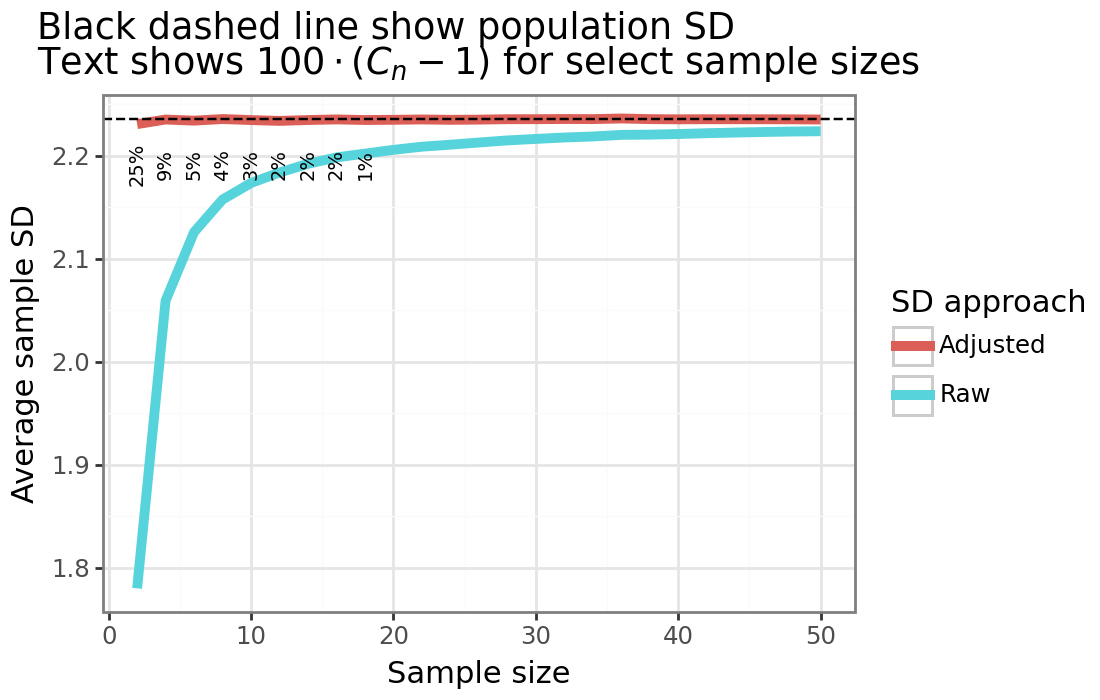

In [3]:
dat_adj_gauss = pd.DataFrame({'n':sample_sizes, 'adj':C_n_gaussian(sample_sizes)}).head(9)

pn.options.figure_size = (5.5, 3.5)
di_gauss_lbl ={'raw': 'Raw', 
               'adj': 'Adjusted'}
gg_gauss = (pn.ggplot(res_gauss, pn.aes(x='n', y='sd', color='msr')) + 
            pn.theme_bw() + 
            pn.geom_line(size=2) + 
            pn.geom_hline(yintercept=sigma, linetype='--') + 
            pn.geom_text(pn.aes(label='(adj-1)*100', y=sigma*0.98), size=7, color='black', format_string='{:.0f}%', angle=90, data=dat_adj_gauss) + 
            pn.scale_color_discrete(name='SD approach', labels = lambda x: [di_gauss_lbl[z] for z in x]) + 
            pn.labs(y='Average sample SD', x='Sample size') + 
            pn.ggtitle('Black dashed line show population SD\nText shows $100\cdot (C_n-1)$ for select sample sizes'))
gg_gauss

The figure above shows that the sample SD can be correctly adjusted for with $C_n$ from EQREF when the underlying data is normally distributed. When the sample size is small, this adjustment factor will be substantial (up to 25% when $n=2$). However, by around 20 samples, the adjustment factor will be 1% or less. Because $C_n$ is only a function of $n$, the same adjustment factor is true for all possible values of $(\mu, \sigma^2)$ which parameterize the normal distribution. When the data is Gaussian therefore, adjustments will be mininal, especially for large samples. As the rest of the post shows however, for non-Gaussian data, this is not always the case, and there can be a substantial bias even for large sample sizes.

### (2.2) Non-normal data: approximations using a series expansion

For non-Gaussian data, the sample variance will not follow any well-defined distribution, and instead we'll either need to appeal to asympotic approximations or finite-sample adjustments. Because we already know that the sample SD is consistent, asymptotic approximation are not of interest, and instead this section will focus on Maclaurin Series expansions that can provide up to fourth-order approximations. As a starting step, $S$ can be re-written as a function of $\sigma$ (notice the RHS reduces to $S$):

$$
S = \sigma [1 + (S^2 - \sigma^2)/\sigma^2]^{1/2}
$$

Next, consider the [binomial series expansion](https://en.wikipedia.org/wiki/Binomial_series):

$$
(1 + x)^{0.5} = 1 + \frac{x}{2} - \frac{x^2}{8} + \frac{x^3}{16} - \frac{5 x^4}{128} +  \dots
$$

Re-writing $x = (S^2 - \sigma^2)/\sigma^2$ we see that:

$$
S = \sigma \Bigg[1 + \frac{1}{2\sigma^2}(S^2 - \sigma^2) - \frac{1}{8\sigma^4}([S^2 - \sigma^2]^2) + \frac{1}{16\sigma^6}([S^2 - \sigma^2]^3) - \frac{5}{128\sigma^8}([S^2 - \sigma^2]^4)  + \dots \Bigg]
$$

Now that we've re-written the sampling SD in terms of an infinite series and removed the square-root, we need to understand how fast the high-order terms tend towards zero as $n$ increases. Remember, $S^2$ is an unbiased estimator of $\sigma^2$ so $S^2-\sigma^2$ always averages to zero, and what we're interested in understanding is how fast the variance decreases. For example, when $X$ comes from a normal distribution, then:

$$
\begin{align*}
S^2 - \sigma^2 &= \sigma^2 \Bigg( \frac{\chi^2_{n-1}}{n-1} -1 \Bigg) \\
&\approx \sigma^2 \cdot N\Bigg(0, \frac{2}{n-1} \Bigg) \\
&\sim N\Bigg(0, \frac{2\sigma^4}{n-1} \Bigg),
\end{align*}
$$

Where the second line uses the [well-known fact](https://en.wikipedia.org/wiki/Chi-squared_distribution#Related_distributions) that $\chi^2_k \overset{d}{\to} N(k, 2k)$. What's nice the sample variance follows a chi-square distribution [asymptotically](https://stats.stackexchange.com/questions/105337/asymptotic-distribution-of-sample-variance-of-non-normal-sample) for any continuous RV, so we can use the above results for the sampling variance more generally:

$$
\begin{align*}
\frac{S^2 - \sigma^2}{\sigma^2} &\approx \sqrt{\frac{2}{\sigma(n-1)}} Z, \hspace{2mm} Z \sim N(0,1) \\
O\Bigg( \sqrt{\frac{2}{\sigma(n-1)}} Z \Bigg) &= O\Bigg( \frac{1}{\sqrt{n}} \Bigg)  \\
O\Bigg( \frac{S^2 - \sigma^2}{\sigma^2}\Bigg) &= O(n^{-1/2}) \hspace{2mm} \longleftrightarrow \\
O\Bigg( \Bigg[ \frac{S^2 - \sigma^2}{\sigma^2} \Bigg]^k \Bigg) &= O(n^{-k/2})
\end{align*}
$$

We can see that the random variable $(S^2 - \sigma^2)/\sigma^2$ has a sampling error that is root-n consistent. And each time this term is raised to the power of $k$, the sampling error decreases by a rate of $k/2$. When $n$ is large, then $O(n^{-0.5})$ implies that that the sample size needs increase by 4x, for the estimator's standard error to fall by 1/2. Whereas for $O(n^{-1})$ and $O(n^{-1.5})$ when the sample size doubles and increases by 59%, respectively, the standard error will half. More generally, the formula to halve the SE will be: $n' = 2^{k / 2} n$, or alternatively, for a doubling of the sample size, the SE will decrease by: $2^{-k/2}$.

Let's check that this is indeed true for the exponential distrubiton: namely, when $n$ is large, if $n' = 2n$, then the standard error of $(S^2 - \sigma^2)/\sigma^2$ will decrease by around $2^{-k/2}$. In the simulation below we'll use the same three rate parameters for the exponential distribution described above, and compare $\text{SE}(S^2_{n'})/\text{SE}(S_n^2)$ when $n=1000$ vs $n'=2000$ over 2500 simulations and see if it equal to $2^{-k/2}$ for $k \in \{1, 2, 3, 4\}$.

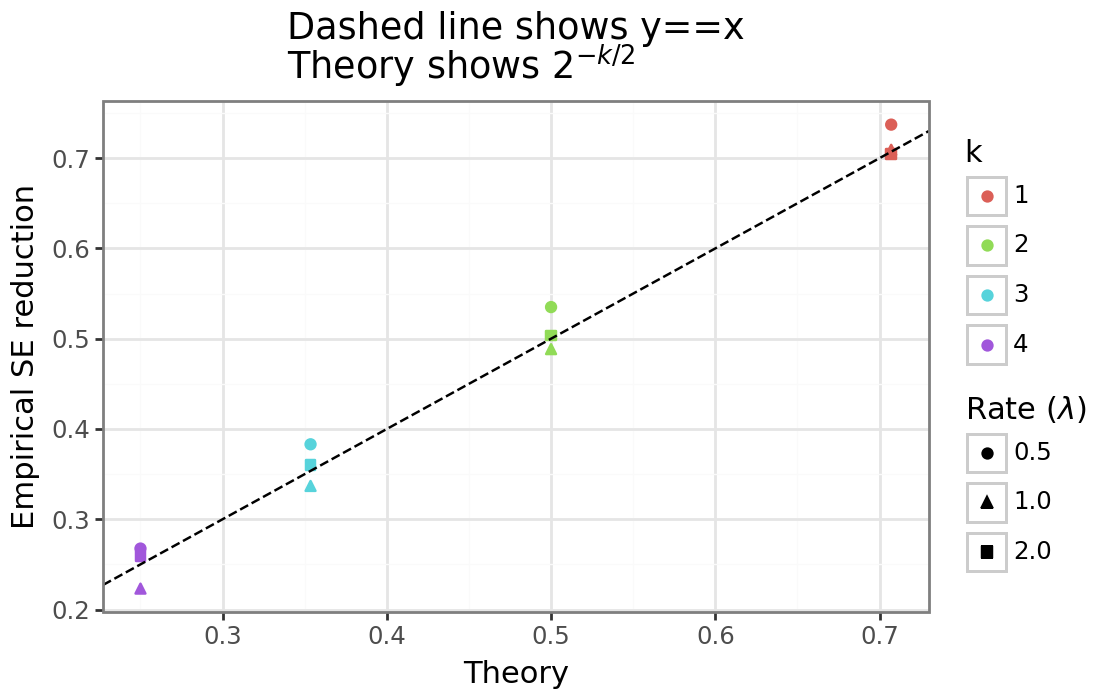

In [4]:
# Set up terms
nsim = 2500
n = 1000
nprime = int(2 * n)
# Draw exponential data and calculate sample variance
S2_n = dist_expon.rvs(size = (n, nsim, n_rates), random_state=1).var(ddof=1, axis=0)
S2_nprime = dist_expon.rvs(size = (nprime, nsim, n_rates), random_state=2).var(ddof=1, axis=0)
# Normalize to oracle variance
norm_var_n = (S2_n - oracle_variance) / oracle_variance
norm_var_nprime = (S2_nprime - oracle_variance) / oracle_variance
# Calculate the theoretical decrease
rate_theory = pd.DataFrame({'k':[1, 2, 3, 4]}).assign(theory=lambda x: 2**(-x['k']/2))

# Calculate the relative variance
res_order = np.vstack([np.std(norm_var_nprime**k, axis=0, ddof=1) / np.std(norm_var_n**k, axis=0, ddof=1) for k in rate_theory['k']])
res_order = pd.DataFrame(res_order.T, columns=rate_theory['k'], index=rates).rename_axis('rate')
res_order = res_order.melt(ignore_index=False, value_name='emp').reset_index()
res_order = res_order.merge(rate_theory)

pn.options.figure_size = (5.5, 3.5)
gg_se_theory = (pn.ggplot(res_order, pn.aes(x='theory', y='emp', color='k.astype(str)', shape='rate.astype(str)'))+ 
          pn.theme_bw() + pn.geom_point() + 
          pn.labs(y='Empirical SE reduction', x='Theory') + 
          pn.ggtitle('Dashed line shows y==x\nTheory shows $2^{-k/2}$') + 
          pn.scale_color_discrete(name='k') + 
          pn.scale_shape_discrete(name='Rate ($\\lambda$)') + 
          pn.geom_abline(slope=1, intercept=0,linetype='--'))
gg_se_theory

The figure above shows that we achieve the variance reduction close to what was expected. As $n$ and the number of simulations gets larger, the results will become increasingly exact.[[^3]]

If we approximate $S$ up to $k=4$ then the remainder term will disappear at a rate of $O(n^{2.5})$; i.e. very quickly.

$$
S = \sigma \Bigg[1 + \frac{1}{2}\frac{S^2 - \sigma^2}{\sigma^2} - \frac{1}{8}\Big(\frac{S^2 - \sigma^2}{\sigma^2}\Big)^2 + \frac{1}{16}\Big(\frac{S^2 - \sigma^2}{\sigma^2}\Big)^3 - \frac{5}{128}\Big(\frac{S^2 - \sigma^2}{\sigma^2}\Big)^4  \Bigg] + O(n^{-2.5})
$$

Next, we can calculate the expected value of this fourth-order approximation (note that $E[S^2 - \sigma^2] = 0$):

$$
E[S] \approxeq \sigma \Bigg[1 - \frac{1}{8}\Big(\frac{E[S^2 - \sigma^2]^2}{\sigma^4}\Big) + \frac{1}{16}\Big(\frac{E[S^2 - \sigma^2]^3}{\sigma^6}\Big) - \frac{5}{128}\Big(\frac{E[S^2 - \sigma^2]^4}{\sigma^8}\Big) \Bigg]
$$

While it's not exactly clear what $E[S^2 - \sigma^2]^k$ would be in general, luckily, existing work by [Angelova (2012)](https://ijpam.eu/contents/2012-79-1/7/7.pdf) has already done this up to $k=4$ (see equation 19), which is shown below and spaced for readability for convenience.

\begin{align*}
\mu_k &= E[X - E(X)]^k \\
\mu_{2,S^2} &= E[S^2 - \sigma^2]^k \\ 
\mu_{2,S^2} &= \frac{(\mu_4 - \mu_2^2)}{n} + \frac{2\mu_2^2}{n(n-1)} \\
\mu_{3,S^2} &= \frac{(\mu_6 - 3\mu_4\mu_2 - 6\mu_3^2 + 2\mu_2^3)}{n^2} + \frac{4(3\mu_4\mu_2 - 5\mu_2^3)}{n^2(n-1)} - \frac{4(\mu_3^2 - 2\mu_2^3)}{n^2(n-1)^2} \\
\mu_{4,S^2} &= \frac{3(\mu_4 - \mu_2^2)^2}{n^2} \\
        &\quad + \frac{(\mu_8 - 4\mu_6\mu_2 - 24\mu_5\mu_3 - 3\mu_4^2 + 24\mu_4\mu_2^2 + 96\mu_3^2\mu_2 - 18\mu_2^4)}{n^3} \\
        &\quad + \frac{12(2\mu_6\mu_2 + 2\mu_4^2 - 17\mu_4\mu_2^2 - 12\mu_3^2\mu_2 + 18\mu_2^4)}{n^3(n-1)} \\
        &\quad - \frac{4(8\mu_5\mu_3 - 36\mu_4\mu_2^2 - 56\mu_3^2\mu_2 + 69\mu_2^4)}{n^3(n-1)^2} \\
        &\quad + \frac{8(\mu_4^2 - 6\mu_4\mu_2^2 - 12\mu_3^2\mu_2 + 15\mu_2^4)}{n^3(n-1)^3} 
\end{align*}

We can now formally define the $k^{th}$ order adjustment for the sample SD:

\begin{align}
C_n(k) &= \begin{cases}
    1 & \text{ if } k = 1 \\
    \Bigg[1 + \sum_{j=2}^k \binom{\frac{1}{2}}{j} \frac{\mu_{j, S^2}}{\sigma^{(2j)}} \Bigg]^{-1} \hspace{2mm} & \text{ for } k \in \{2, 3, 4\}
\end{cases}

\end{align}

Note that [Giles (2021)](http://web.uvic.ca/~dgiles/downloads/working_papers/std_dev.pdf) defines EQREF for $k=2$, which can be written as a function of the empirical kurtosis. To make the approach more modular, I have left the terms as they are (i.e. not re-factored as central moments like kurtosis). This means that were an oracle calculating $C_n$ for up to $k=4$, it would need to know the central moments of $X$ up to eigth power. In practice, estimates of each will need to be provided from the data. When the parametric form of $X$ is known, then the central moments will usually be a function of that distribution's population parameter(s) and can be substituted in for a simple MLE estimate. When $X$ comes from an unknown distribution, then the empirical moments will need to be provided. In either case, there will be a bias/variance tradeoff, and using $C_n(1)=S$ may be better than $C_n(k)$ for $k \geq 2$.

## (2.3) Oracle adjustment for the exponential distribution 

Before having to actually estimate $C_n(k)$ with data, let us first examine how much bias is removed when it calculated analytically in the case of an exponential distribution. This distribution's [central moments](https://en.wikipedia.org/wiki/Exponential_distribution#Mean,_variance,_moments,_and_median) can be analytically written as a function of its rate parameter: $\mu_k(\lambda) = \frac{k!}{\lambda^k} \sum_{j=0}^k \frac{(-1)^j}{j!}$. The first code block below provides a python implementation for both the central moment generator of an exponential distribution as well as a generic function to calculate $\mu_{k,S^2}$ when a `moment_func` is provided values for $k \in \{1, 2, 3, 4\}$.

In [5]:
from math import factorial
from scipy.special import binom
from typing import Callable, Tuple, List

class CentralExpMoments:
    def __init__(self, lambd: float):
        """
        Calculates the central moments of an exponential distribution for same rate parameter (lambd): X ~ Exp(lambd)

        \mu_k(\lambda) = E[(X - E(X))^k] = \frac{k!}{\lambda^k} \sum_{j=0}^k \frac{(-1)^j}{j!}
        """
        self.lambd = lambd

    def __call__(self, k: int) -> float:
        """Return the k'th central moment"""
        factorial_k = factorial(k)
        sum_term = sum(((-1)**j) / factorial(j) for j in range(k + 1))
        moment = (factorial_k / (self.lambd**k)) * sum_term
        return moment


def mu_k_S2(k:int | List | Tuple, n: int, moment_func: Callable) -> np.ndarray:
    """
    Calculate \mu_{k, S^2} = E[(S^2 - \sigma^2)]^k for k={1,2,3,4}

    Args
    ====
    k: int
        A list of orders to calculate (or a single term if int)
    n: int
        The sample size
    moment_func:
        A function to calculate the (central) moment for the assumed distribution of X where moment_func(k) = E[(E-E(X))^k]
    """
    # Input checks
    valid_k = [1, 2, 3, 4]
    if isinstance(k, int):
        k = [k]
    assert all([j in valid_k for j in k]), f'k must be one {valid_k}'
    k_max = max(k)
    
    # Calculate necessary moments
    if k_max >= 2:
        mu2 = moment_func(2)
        mu3 = moment_func(3)
        mu4 = moment_func(4)
    if k_max >= 3:
        mu5 = moment_func(5)
        mu6 = moment_func(6)
    if k_max == 4:
        mu8 = moment_func(8)

    # Calculate the adjustment terms
    val = []
    if 1 in k:
        mu_1_S2 = 0
        val.append(mu_1_S2)
    if 2 in k:
        mu_2_S2 = (mu4 - mu2**2) / n + 2 * mu2**2 / (n * (n - 1))
        val.append(mu_2_S2)
    if 3 in k:
        mu_3_S2 = (mu6 - 3 * mu4 * mu2 - 6 * mu3**2 + 2 * mu2**3) / n**2 + \
             4 * (3 * mu4 * mu2 - 5 * mu2**3) / (n**2 * (n - 1)) - \
             4 * (mu3**2 - 2 * mu2**3) / (n**2 * (n - 1)**2)
        val.append(mu_3_S2)
    if 4 in k:
        mu_4_S2 = 3 * (mu4 - mu2**2)**2 / n**2 + \
                (mu8 - 4 * mu6 * mu2 - 24 * mu5 * mu3 - 3 * mu4**2 + 24 * mu4 * mu2**2 + 96 * mu3**2 * mu2 - 18 * mu2**4) / n**3 + \
                12 * (2 * mu6 * mu2 + 2 * mu4**2 - 17 * mu4 * mu2**2 - 12 * mu3**2 * mu2 + 18 * mu2**4) / (n**3 * (n - 1)) - \
                4 * (8 * mu5 * mu3 - 36 * mu4 * mu2**2 - 56 * mu3**2 * mu2 + 69 * mu2**4) / (n**3 * (n - 1)**2) + \
                8 * (mu4**2 - 6 * mu4 * mu2**2 - 12 * mu3**2 * mu2 + 15 * mu2**4) / (n**3 * (n - 1)**3)
        val.append(mu_4_S2)
    
    val = np.array(val)
    return val

To make sure that `mu_k_S2` works as expected, we can compare the average value of the difference between the sample variance and the population variance to the powers of 1, 2, 3, and 4 for 1-million simulations and compare to this values expected from $\mu_{k,S^2}$ when the data is drawn from $X \sim \text{Exp}(2)$ and the central moments known with oracle precision.

In [6]:
from scipy.stats import ttest_1samp
# Set up parameters
seed = 1234
lambd = 2
sample_size = 2
nsim = 1000000
Xdist = expon(scale = 1 / lambd)
k_orders = [1, 2, 3, 4]
# Calculate population/oracle values
sigma2 = Xdist.var()
central_Exp_moments = CentralExpMoments(lambd = lambd)
theory_mu_S2 = mu_k_S2(k = k_orders, n = sample_size, moment_func=central_Exp_moments)

# Draw data and calculate sample variance
S2 = Xdist.rvs(size = (nsim, sample_size), random_state=seed).var(axis=1, ddof=1)
hat_mu_S2 = np.array([np.mean((S2 - sigma2)**k) for k in k_orders])
pval_mu_1_S2 = np.array([ttest_1samp(a = (S2 - sigma2)**k, popmean=theory_mu_S2[i]).pvalue for i,k in enumerate(k_orders)])
# Show that results are within theory
pd.DataFrame({'k':k_orders, 
              'Theory':theory_mu_S2,
              'Empirical':hat_mu_S2,
              'P-value':pval_mu_1_S2}).round(4)

,k,Theory,Empirical,P-value
0,1,0.0000,-0.0005,0.3988
1,2,0.3125,0.3076,0.0770
2,3,1.1562,1.0984,0.0793
3,4,8.5664,7.6422,0.1143


As expected, the empirical averages are statistically indistinguishable from the theoretical mean showing that Angelova (2012) derivations hold. The next code block provides the `C_n_adj` function which takes in a value of `k` and a `moment_func` and returns the adjustment factor. 

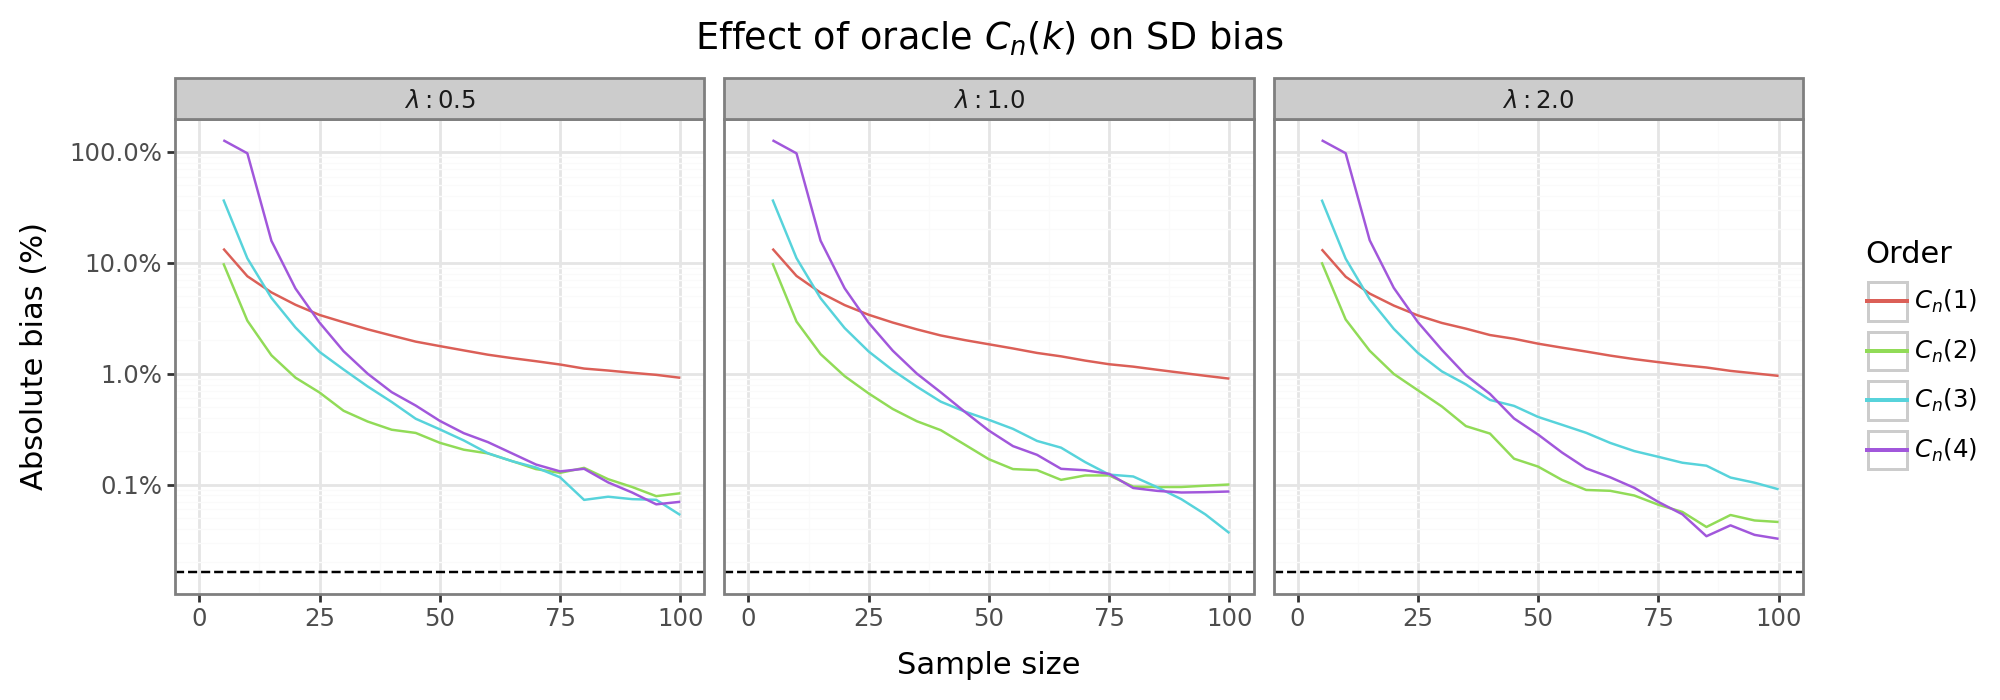

In [7]:
from mizani.formatters import percent_format

def C_n_adj(k:int, n: int, moment_func: Callable) -> float | Tuple:
    """
    Calculate the adjustment factor for: C_n(k) &= \Bigg[1 + \sum_{j=2}^k \binom{\frac{1}{2}}{j} \frac{\mu_{k, S^2}}{\sigma^{(2k)}} \Bigg]^{-1}

    Args
    ====
    k: int
        A list of orders to calculate (or a single term if int)
    n: int
        The sample size
    moment_func:
        A function to calculate the (central) moment for the assumed distribution of X where moment_func(k) = E[(E-E(X))^k]
    """
    # Input checks
    assert k in [1, 2, 3, 4], 'k needs to be {1, 2, 3, 4}'
    assert isinstance(n, int), 'n needs to be an int'
    if k == 1:
        return 1  # no adjustmemt needed
    k_seq = list(range(2, k + 1))
    # Calculate the E[S^2 - sigma^2]^k and sigma^2
    mu_k_seq = mu_k_S2(k=k_seq, n=n, moment_func=moment_func)
    sigma2 = moment_func(2)
    # Calculate the adjustment term
    coef_binom = np.array([binom(0.5, j) for j in k_seq])
    sigma2_seq = np.array([sigma2 ** j for j in k_seq])
    C_n = 1 / (1 + np.sum(coef_binom * mu_k_seq / sigma2_seq))
    return C_n

# Run the simulations
nsim = 100000
k_seq = [1, 2, 3, 4]
sample_sizes = np.arange(5, 100+1, 5)
# Calculate adjustment factors
adjust_factors = np.vstack([np.array([C_n_adj(k=k, n=int(n), moment_func=central_Exp_moments) for n in sample_sizes]) for k in k_seq]).T
# Calculate the average sample SD
S_hat_bar = np.vstack([dist_expon.rvs(size = (nsim, n, n_rates), random_state=seed).std(axis=1, ddof=1).mean(axis=0) for n in sample_sizes])
S_hat_bar_adj = np.expand_dims(S_hat_bar, 2) * np.expand_dims(adjust_factors,1)
# Calculate the percentage error to population param
pct_deviation = S_hat_bar_adj / np.atleast_3d(np.sqrt(dist_expon.var())) - 1
res_pct_deviation = pd.concat(objs=[pd.DataFrame(pct_deviation[:,:,j],index=sample_sizes,columns=rates).assign(k=k) for j,k in enumerate(k_seq)])
res_pct_deviation.rename_axis('sample_size', inplace=True)
res_pct_deviation.set_index('k',append=True, inplace=True)
res_pct_deviation = res_pct_deviation.melt(ignore_index=False, var_name='lambd', value_name='pct')
res_pct_deviation.reset_index(inplace=True)

di_k = {str(k):f'$C_n({k})$' for k in k_seq}
pn.options.figure_size = (10, 3.5)
di_rates = {str(r):f'$\\lambda: {r}$' for r in rates}
gg_pct_dev = (pn.ggplot(res_pct_deviation, pn.aes(x='sample_size', y='pct.abs()', color='k.astype(str)')) + 
              pn.theme_bw() + pn.geom_line() + 
              pn.scale_y_log10(labels=percent_format()) + 
              pn.scale_x_continuous(limits=[0, max(sample_sizes)]) + 
              pn.facet_wrap('~lambd', nrow=1, labeller=pn.labeller(cols=lambda x: di_rates[x])) + 
              pn.geom_hline(yintercept=res_pct_deviation.pct.abs().min()*0.5, linetype='--') + 
              pn.scale_color_discrete(name='Order',labels = lambda x: [di_k[z] for z in x]) + 
              pn.labs(y='Absolute bias (%)', x='Sample size') + 
              pn.ggtitle('Effect of oracle $C_n(k)$ on SD bias'))
gg_pct_dev

The figure above shows the absolute bias (on the log scale) of the sample SD after the oracle adjustment for the SDs of the three different exponential distributions (i.e. $|\hat\sigma / \sigma - 1|$). For small sample sizes, the second and third order adjustments, $C_n(\{3,4\})$, are more biased than the vanilla sample SD: $C_n(1)$. This is not that surprising since the binomial series expansion only converges when $x < 1$, so $|[S^2 - \sigma^2]^k/\sigma^{2k}|<1$. For small $n$ the expansion may therefore not be stable. In contrast, the first order adjustment ($C_n(2)$) always dominates the vanilla SD. Are higher order adjustments ever preferable over the first order adjustment? In this example, somehwere around $n=75$, using higher order oracle adjustment can decrease the bias, but only marginally. The fact that in these terms will need to estimated in applied settings means that in practice, the only feasible SD estimators will be vanilla or first-order adjustment. 

## (3) Bias-variance trade-off

Section (2.3) showed that even with oracle precision, second- and third-order adjustments are unlikely to be helpful with combatting the bias of the sample SD. Therefore, this section will focus on comparing the vanilla SD with the first-order adjustment, as the latter dominates in the oracle situation. However, once we actually need to estimate the terms that go into this adjustment, it's not clear *a priori* whether it will be a better estimator. The reasons for this are two-fold. First, the adjustment term requires estimating a higher-order moment of the distribution. Just as estimating the SD with its sample counterpart leads to a biased estimator, the estimators for the fourth moment or variance squared will also be biased. Second, even if the terms could be estimated without any bias, the variance of the estimator will necessarily be larger. We can therefore think about the quality of the estimator in terms of the expected value of a loss function like the mean squared error or mean absolute error. This expected value, the risk of the estimator, will therefore have a [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) for which the rest of this section will explore. 

Focusing on the first-order expansion, we can simplify the terms seem in equation REF:

$$
\begin{align}
\sigma &\approx E[S] \cdot \underbrace{\Bigg[1 - \frac{1}{8n}\Bigg(\kappa - 1 + \frac{2}{(n-1)} \Bigg) \Bigg]}_{C_n^{-1}(2)}
\end{align}
$$

So that the adjustment factor is a function of the sample size, $n$, and the [kurtosis](https://en.wikipedia.org/wiki/Kurtosis), $\kappa = E[(X - \mu)^4/\sigma^4]$. This population parameter can estimated [non-parametrically](https://www.jstor.org/stable/2988433). If one "knows" the parametric form of the data, then the kurtosis may be a function of the population parameters. 

## (3.1) Kurtosis estimator

This subsection will first analyze the bias and variance of estimating the kurtosis necessary for calculating the adjustment in equation EQREF, when the data is drawn from a binomial distribution. The kurtosis will be estimated with both parametric and non-parametric approaches. Denote a draw from the binomial distribution as $X \sim \text{Bin}(p,m)$, where $p$ is the probability of success and $m$ is the number of draws. It is easy to show that the kurtosis is a function of the population parameters: $\text{Kurt}(X)=\kappa = 3 - 6/m + [mp(1-p)]^{-1}$. Since $m$ is assumed to be known, after $p$ is estimated, a "plug-and-play" estimate is derived. For the non-parametric case, we can use either the bias [adjusted or un-adjusted approaches](https://en.wikipedia.org/wiki/Kurtosis#Standard_unbiased_estimator):[[^4]]

$$
\begin{align*}
\kappa^{\text{para}} &= 3 - 6/m + [m\cdot\hat{p}\cdot(1-\hat{p}) ]^{-1} \\
\hat{p} &= n^{-1} \sum_{i=1}^n (X_i / m) \\
\kappa^{\text{unj}} &= \frac{n^{-1}\sum_{i=1}^n (X_i - \bar{X})^4}{\Big[n^{-1}\sum_{i=1}^n (X_i - \bar{X})^2 \Big]^2} \\
\kappa^{\text{adj}} &= \frac{(n^2-1)\kappa^{\text{unj}} - 9n + 15}{(n-2)(n-3)}
\end{align*}
$$

The code below run 100K simulations for estimating the (known) kurtosis for a binomial distribution with $p \in \{0.1, 0.3, 0.5 \}$ and $m=20$ for sample sizes between $\{ 5, 10, \dots, 50 \}$. The average squared error (MSE), absolute error (MAE), bias, and variance is shown for the there different estimators shown above.

In [18]:
# Load extra functions
from scipy.stats import binom, kurtosis
from mizani.palettes import hue_pal

# Set up binomial distribution
seed = 2
nsim = 100000
sample_sizes = np.arange(5, 50 + 1, 5)
m = 20
p_seq = [0.1, 0.3, 0.5]
n_p = len(p_seq)
dist_binom = binom(n=m, p=p_seq)
# scipy defines kurtosis as "excess" relative to the Gaussian, so add back 3
kappa0 = dist_binom.stats('k') + 3
dat_kappa0 = pd.DataFrame({'p':p_seq, 'kappa':kappa0})
# Loop over the different sample sizes
holder_binom = []
for sample_size in sample_sizes:
    # Draw data
    X = dist_binom.rvs(size=[sample_size, nsim, n_p], random_state=seed)
    Xbar = X.mean(axis=0)
    mu4 = np.mean((X - Xbar)**4, axis=0)
    mu22 = np.mean((X - Xbar)**2, axis=0)**2
    # Calculate different kappa variants
    p = Xbar / m
    p[p == 0] = 1 / m
    kappa_para =  3 - 6/m + 1/(m*p*(1-p)) 
    kappa_np_unj = kurtosis(a=X, fisher=False, bias=True, axis=0)
    kappa_np_adj = kurtosis(a=X, fisher=False, bias=False, axis=0)
    # Check that it aligns with expectation
    np.testing.assert_almost_equal(kappa_np_unj, mu4 / mu22)
    np.testing.assert_almost_equal(kappa_np_adj, ( (sample_size**2-1)*mu4/mu22 - 9*sample_size + 15 ) / ((sample_size-2)*(sample_size-3)) )
    # Calculate the bias/variance/MSE/MAE
    di_kappa = {'para':kappa_para, 'np_unj':kappa_np_unj, 'np_adj':kappa_np_adj}
    res_kappa = pd.concat(objs=[pd.DataFrame(pd.DataFrame(v, columns=p_seq).assign(method=k)) for k,v in di_kappa.items()])
    res_kappa = res_kappa.melt('method', var_name='p').merge(dat_kappa0)
    res_kappa = res_kappa.groupby(['method','p']).apply(lambda x: pd.Series({
        'bias': np.mean(x['kappa'] - x['value']),
        'variance': np.var(x['kappa'] - x['value']),
        'MSE': np.mean((x['kappa'] - x['value'])**2), 
        'MAE': np.mean(np.abs(x['kappa'] - x['value']))})
    )
    res_kappa = res_kappa.melt(ignore_index=False, var_name='msr').reset_index()
    res_kappa.insert(0, 'n', sample_size)
    del di_kappa, kappa_para, kappa_np_unj, kappa_np_adj
    holder_binom.append(res_kappa)

# Merge all results
res_kappa = pd.concat(holder_binom)

/tmp/ipykernel_201483/3137787112.py:27: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
/tmp/ipykernel_201483/3137787112.py:28: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
/tmp/ipykernel_201483/3137787112.py:30: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_201483/3137787112.py:31: RuntimeWarning: invalid value encountered in divide


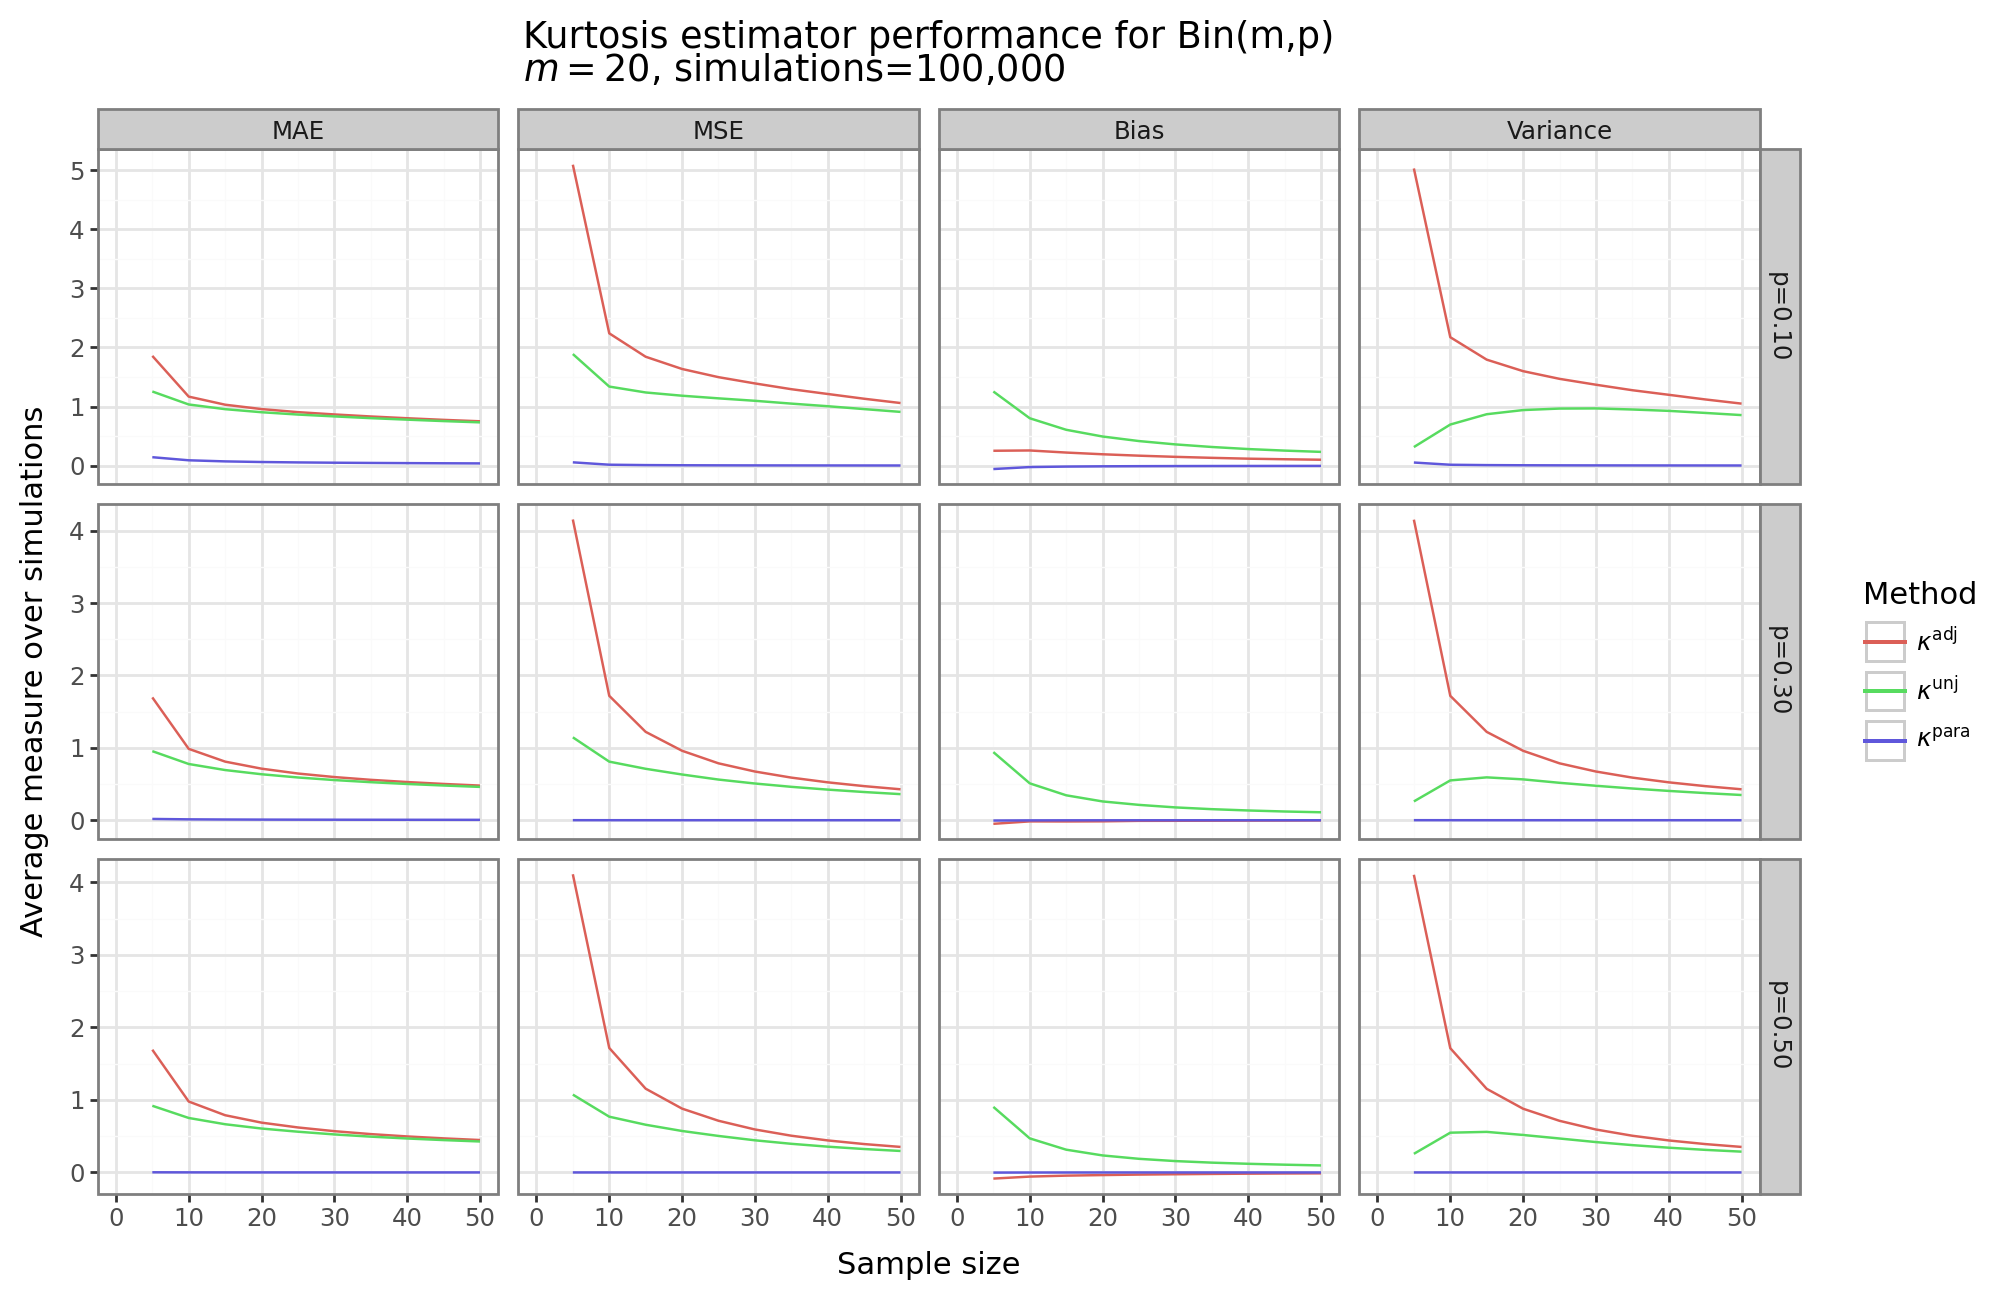

In [78]:
di_method = {'np_adj':'$\\kappa^{\\text{adj}}$', 
             'np_unj':'$\\kappa^{\\text{unj}}$',
             'para': '$\\kappa^{\\text{para}}$'}
di_msr = {'bias':'Bias', 
          'variance': 'Variance', 
          'MSE':'MSE', 'MAE':'MAE'}
di_p = {str(p):f'p={p:.2f}' for p in p_seq}

colorz = hue_pal()(3)
pn.options.figure_size = (10, 6.5)
gg_kappa = (pn.ggplot(res_kappa, pn.aes(x='n', y='value', color='method')) + 
            pn.theme_bw() + pn.geom_line() + 
            pn.labs(x = 'Sample size', y='Average measure over simulations') + 
            pn.scale_x_continuous(limits=[0, sample_sizes[-1]]) + 
            pn.ggtitle(f'Kurtosis estimator performance for Bin(m,p)\n$m={m}$, simulations={nsim:,}') + 
            pn.scale_color_manual(name='Method', labels=lambda x: [di_method[z] for z in x], values=colorz) + 
            pn.facet_grid('p~msr', labeller=pn.labeller(rows=lambda x: di_p[x], cols = lambda x: di_msr[x]),scales='free_y')
            )
gg_kappa

The figure above shows four different measures of the kurtosis estimator performance for three different parameter values of the binomial distriubtion for the parametric and non-parametric approaches as a function of the sample size. As would be expected, all estimators decrease their MSE and MAE as the sample size increases. However, the parametric "plug-and-play" approach dominates. This shows that when the parametric form of the data is known, and an analytical expression for the kurtosis can be written in terms of its parameters estimable by MLE, then the parametric kurtosis estimator is likely the sensible choice.[[^5]]

For the non-parametric approaches, the unadjusted approach, interestingly, does better in terms of MAE/MSE. The reason for this can be seen in the "Bias" and "Variance" columns. While the unadjusted approach has much higher bias (indeed both the parametric and adjusted methods have close to zero bias for these three binomial distributions), its variance is substantially lower that the adjusted approach. For example, when $n=5$, then the adjustment factor is four, and the variance is concomitantly sixteen-fold higher for the adjusted method. 

While this section has shown the relative merits of the different kurtosis estimators, we need to check how they fare when actually estimating the SD of a distribution.

## (3.2) Binomial SD

We will continue our binomial distribution example and this time focus on the same four measures of estimator performace (MSE, MAE, variance, bias) but for the distribution's SD, rather than its kurtosis. While a noisier kurtosis estimator will increase the MSE/MAE, *ceteris paribus*, the final MSE/MAE for the SD will depend on the relative magnitude of the variance, and the relative change in the bias of the SD. 

The code below runs create a new function `sd_adj` which will use the first-order approximation when `kappa` is provided from EQREF. The simulation parameters are the same as the binomial distribution described above. 

In [90]:
def sd_adj(x: np.ndarray, kappa: np.ndarray | None = None, ddof:int = 1, axis: int | None = None) -> np.ndarray:
    """
    Adjust the vanilla SD estimator 
    """
    std = np.std(x, axis=axis, ddof = ddof)
    nrow = x.shape[0]
    if kappa is not None:
        adj = 1 / ( 1 - (kappa - 1 + 2/(nrow-1)) / (8*nrow) ) 
        std = std * adj
    return std
    

# Calculate the population SD
dat_sd_binom = pd.DataFrame({'p':p_seq, 'sd':np.sqrt(dist_binom.stats('v'))})

# Loop over each sample size
holder_binom = []
for sample_size in sample_sizes:
    # Draw data
    X = dist_binom.rvs(size=[sample_size, nsim, n_p], random_state=seed)
    # Calculate different kappa variants
    p = X.mean(axis = 0) / m
    p[p == 0] = 1 / (m + 1)
    kappa_para =  3 - 6/m + 1/(m*p*(1-p)) 
    kappa_np_unj = kurtosis(a=X, fisher=False, bias=True, axis=0)
    kappa_np_adj = kurtosis(a=X, fisher=False, bias=False, axis=0)
    # Estimate the SD
    sigma_vanilla = sd_adj(x=X, axis=0)
    sigma_para = sd_adj(x=X, axis=0, kappa=kappa_para)
    sigma_unj = sd_adj(x=X, axis=0, kappa=kappa_np_unj)
    sigma_adj = sd_adj(x=X, axis=0, kappa=kappa_np_adj)
    # Calculate the bias/variance/MSE/MAE
    di_sigma = {'vanilla':sigma_vanilla, 'para':sigma_para, 
                'np_unj':sigma_unj, 'np_adj':sigma_adj}
    res_sigma = pd.concat(objs=[pd.DataFrame(pd.DataFrame(v, columns=p_seq).assign(method=k)) for k,v in di_sigma.items()])
    res_sigma = res_sigma.melt('method', var_name='p').merge(dat_sd_binom)
    res_sigma = res_sigma.groupby(['method','p']).apply(lambda x: pd.Series({
        'mu': np.mean(x['value']), 
        'bias': np.mean(x['sd'] - x['value']),
        'variance': np.var(x['sd'] - x['value']),
        'MSE': np.mean((x['sd'] - x['value'])**2), 
        'MAE': np.mean(np.abs(x['sd'] - x['value']))})
    )
    res_sigma = res_sigma.melt(ignore_index=False, var_name='msr').reset_index()
    res_sigma.insert(0, 'n', sample_size)
    del di_sigma, sigma_vanilla, sigma_para, sigma_unj, sigma_adj
    holder_binom.append(res_sigma)
# Merge results
res_sd_binom = pd.concat(holder_binom)


/tmp/ipykernel_201483/1789314366.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
/tmp/ipykernel_201483/1789314366.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


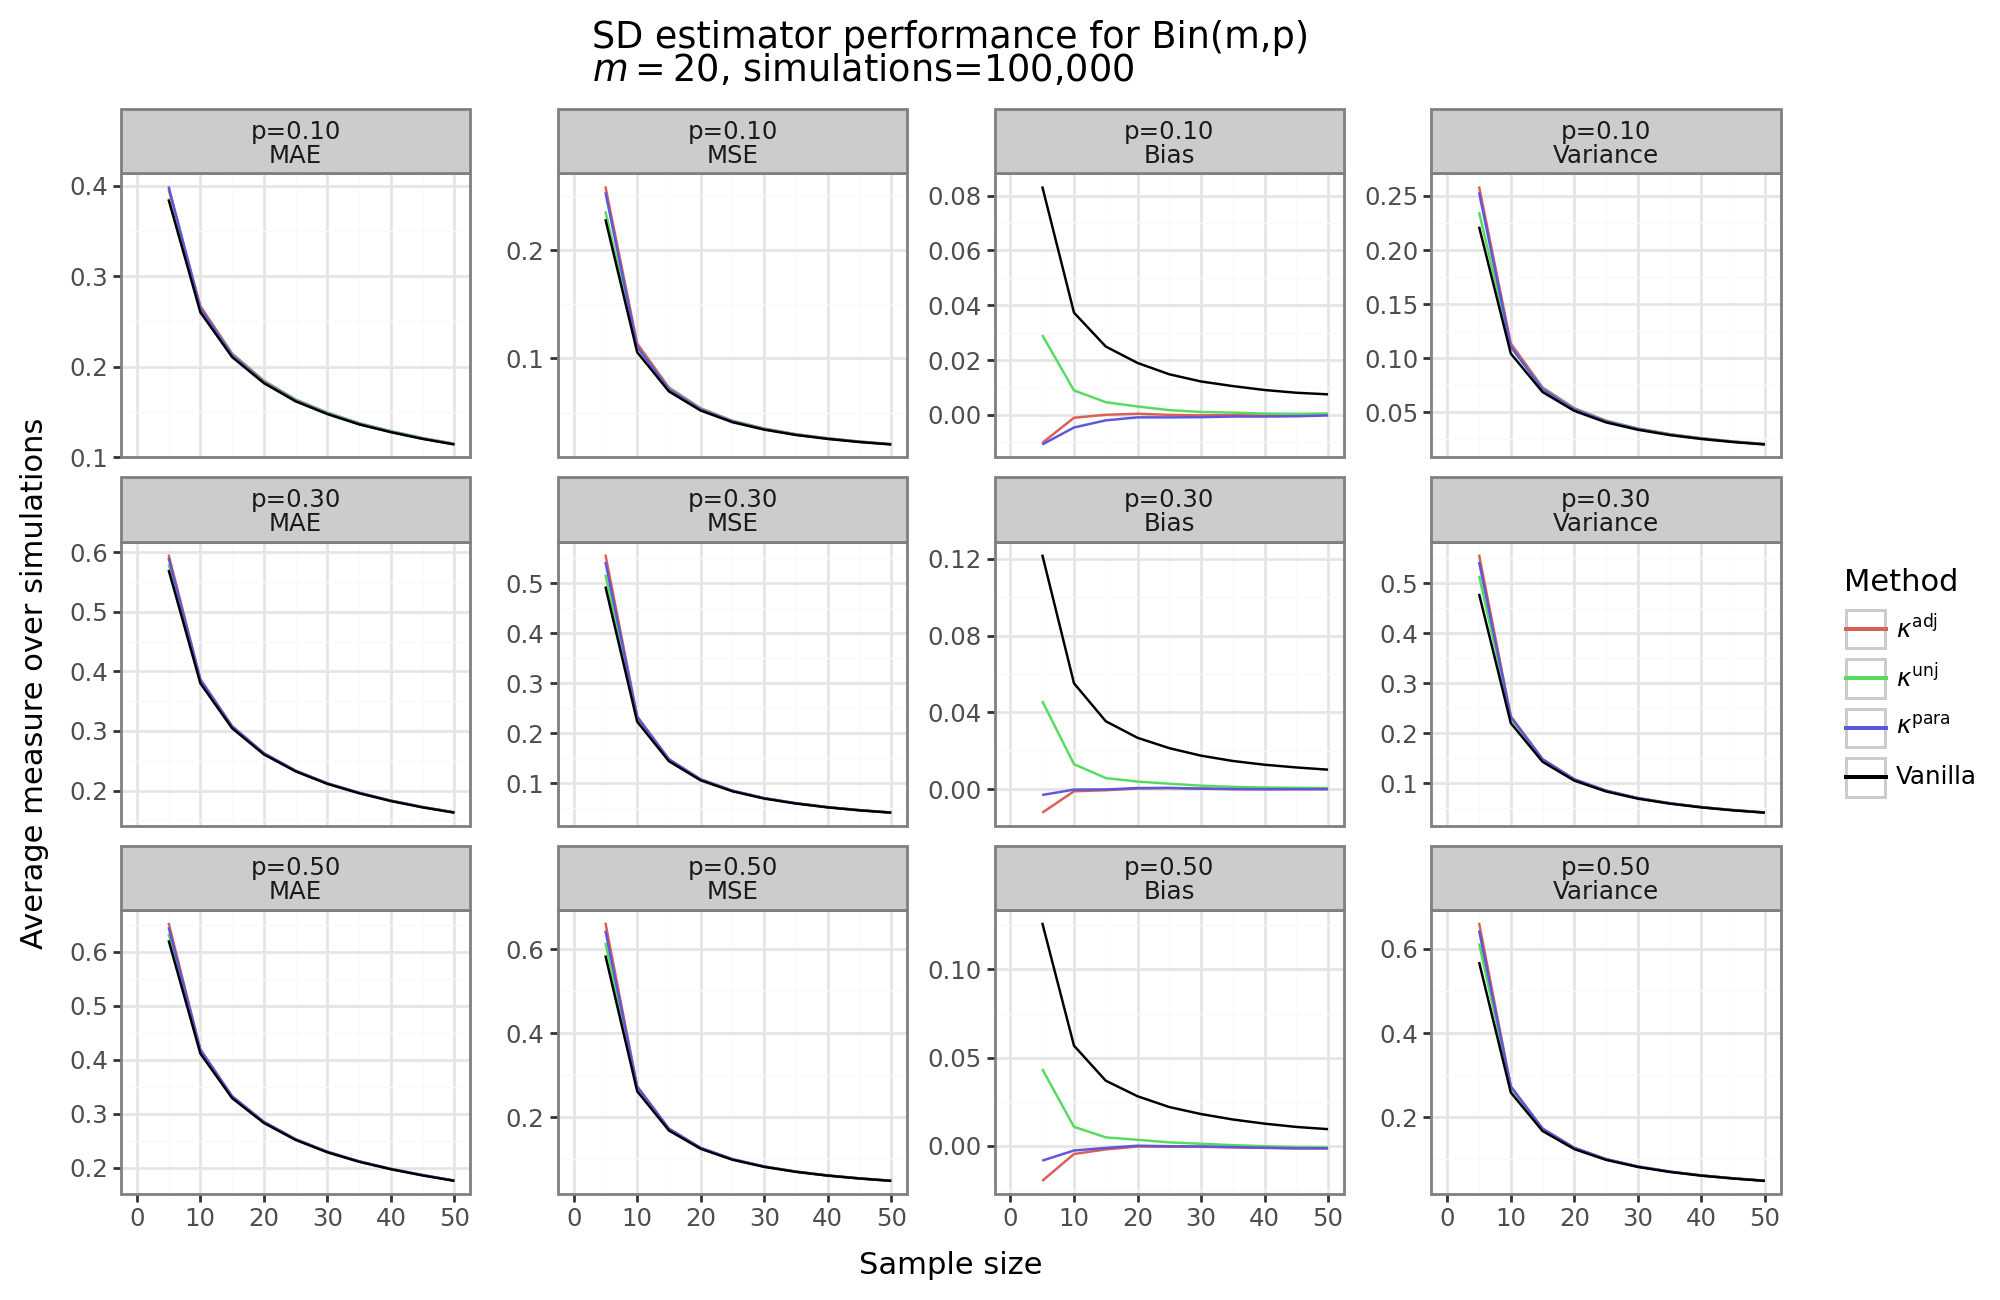

In [91]:
# Plot the performance
di_method = {**{'vanilla':'Vanilla'}, **di_method}

# Subset the dat
dat_plot = res_sd_binom.query('msr!= "mu"').copy()

colorz = hue_pal()(3) + ['black']
pn.options.figure_size = (10, 6.5)
gg_perf_binom = (pn.ggplot(dat_plot, pn.aes(x='n', y='value', color='method')) + 
            pn.theme_bw() + pn.geom_line() + 
            pn.labs(x = 'Sample size', y='Average measure over simulations') + 
            pn.scale_x_continuous(limits=[0, sample_sizes[-1]]) + 
            pn.ggtitle(f'SD estimator performance for Bin(m,p)\n$m={m}$, simulations={nsim:,}') + 
            pn.scale_color_manual(name='Method', labels=lambda x: [di_method[z] for z in x], values=colorz) + 
            pn.facet_wrap('~p+msr', labeller=pn.labeller(cols = lambda x: {**di_p, **di_msr}[x]), scales='free_y')
            )
gg_perf_binom

In [104]:
res_sd_binom.groupby(['method', 'msr'])['value'].mean().unstack().round(3)

msr,MAE,MSE,bias,mu,variance
method,,,,,
np_adj,0.251,0.124,-0.002,1.878,0.124
np_unj,0.249,0.120,0.006,1.869,0.120
para,0.250,0.123,-0.001,1.877,0.123
vanilla,0.247,0.117,0.030,1.846,0.115


The figure above shows that the MAE/MSE for almost all of our kurtosis estimators is largely the same. While the bias for all of the adjustment methods is better, the magnitude of this bias is dwarfed by the variance of SD estimator. The vanilla estimator (i.e. square-root of the sample variance), has highest bias, the lowest variance, and the lowest MAE/MSE. The parametric method dominates the adjusted non-parameteric approach in that it has slightly less bias but lower variance. However, the non-adjusted non-parametric approach, like the vanilla estimator, has higher bias than either the parametric or adjustment approach, but lower variance and a lower MSE/MAE. Hence, for use cases where having a biased estimator is problematic, and we are willing to pay for it with a bith of variance, any one of our adjustment methods could be worth it.[[^6]]

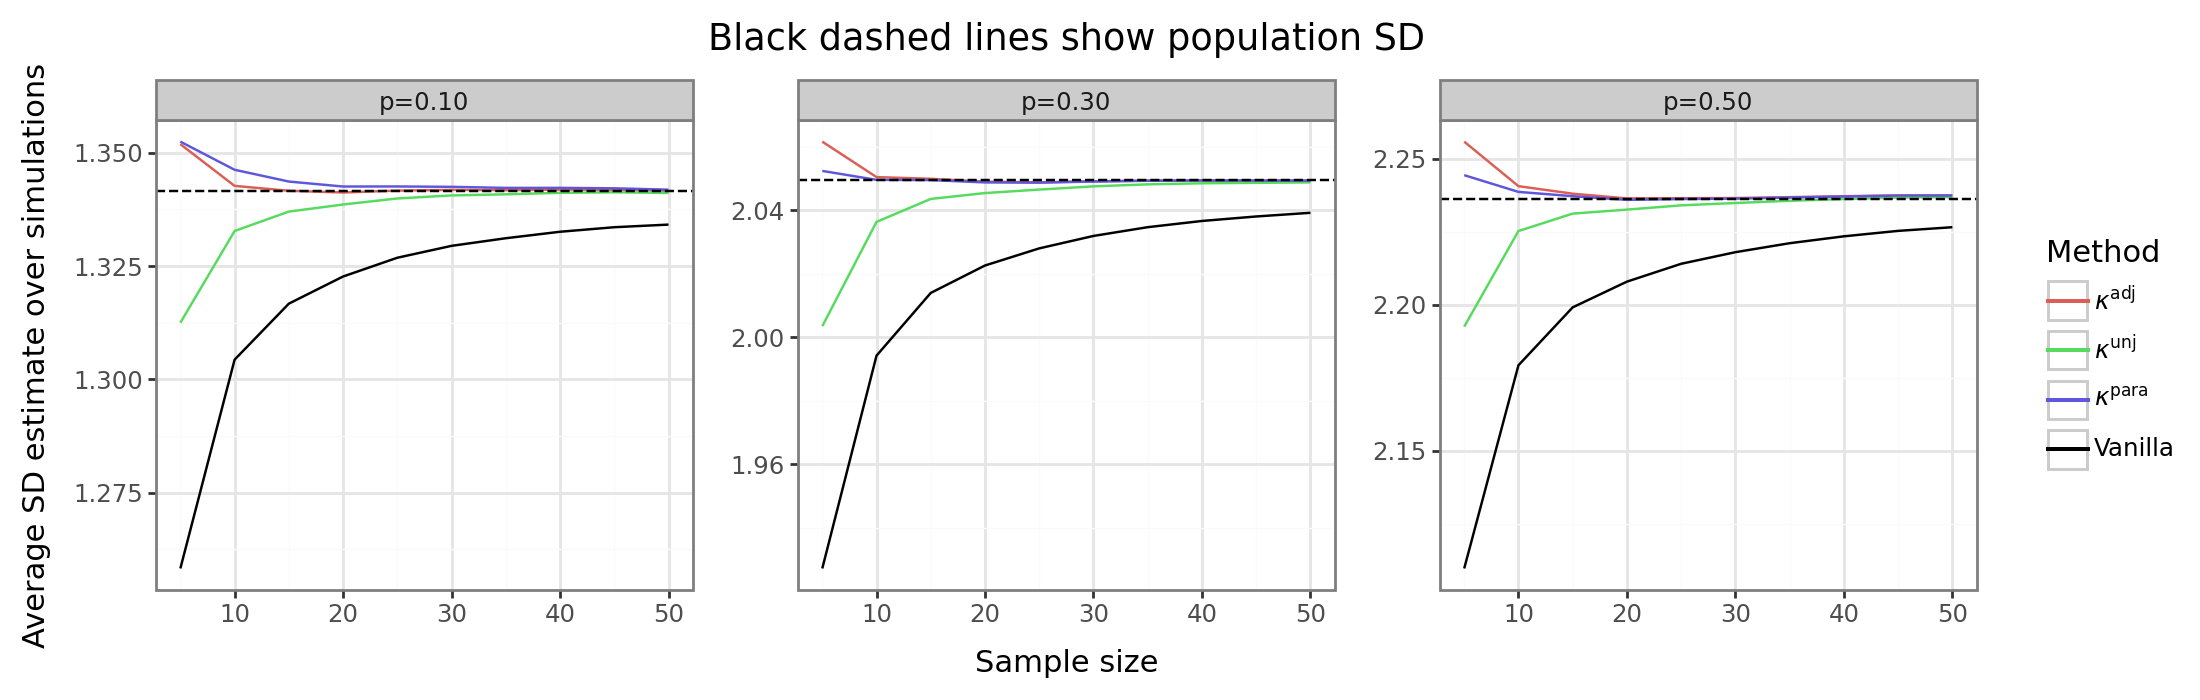

In [95]:
# Plot the actual vs oracle
dat_plot = res_sd_binom.query('msr == "mu"').merge(dat_sd_binom)

pn.options.figure_size = (11, 3.5)
gg_sd_binom = (pn.ggplot(dat_plot, pn.aes(x='n', y='value', color='method')) + 
            pn.theme_bw() + pn.geom_line() + 
            pn.facet_wrap(facets='~p', scales='free', labeller=pn.labeller(cols = lambda x: di_p[x])) + 
            pn.scale_color_manual(name='Method', labels=lambda x: [di_method[z] for z in x], values=colorz) + 
            pn.geom_hline(pn.aes(yintercept='sd'), data=dat_sd_binom, linetype='--') + 
            pn.labs(y='Average SD estimate over simulations', x='Sample size') + 
            pn.ggtitle('Black dashed lines show population SD'))
gg_sd_binom

The figure above shows the average SD estimate over all simulation runs compared to the population parameter. Interestingly, we see that the while the use of the first-order adjustment reduces the bias, only the parameteric or adjusted methods yield a *conservative* estimator, while the unadjusted method yields an optimistic estimator, albeit less biased than the unadjusted method. This distinction is important because there may be contexts when we prefer the bias to be one direction over another. For example, if the SD is used as a way to generate a type of z-score, then an optimistic estimator may have inflated type-I errors, whereas a conservative estimator will have deflated type-I errors and reduced power.

## (4) Regression application

The examples in this post so far have been for known parametric distributions with a single estimable parameter. This has been useful for generating many simulation results quickly and comparing the estimators to the true population parameter. In practice, of course, we will never have a method for knowing the population parameter, and will usually be unaware of the distribution as well. In this section, I will try to ground our results for an application I have discussed elsewhere. Namely, estimating the SD of some residual function (e.g. absolute errors, squared errors, cross-entropy, etc). This parameter turns out to useful for doing statistical testing on, since the loss functions for many ML models will have a normal distribution for large samples (due to the central limit theorem). 



## (5) Conclusion

This post has has provided a thorough overview of what causes the traditional SD estimator to be biased, and methods to help de-bias it.

## References

[^1]: And if the data is Gaussian, the sample variance actually has a chi-squared distribution and therefore *exact* confidence intervals can be generated.

[^2]: Note that an alternative formulation a la [Cureton (1968)](https://www.tandfonline.com/doi/pdf/10.1080/00031305.1968.10480435) is to re-write the sample SD as $S = \sqrt{\sum_i (X_i \bar{X})^2 / k_n}$ so that we have a different adjustment factor that the usual Bessel Correction.

[^3]: As in, if $n$ is very large, like $n=1e8$ vs $n=2e8$, then the SE reduction will be close to exact.

[^4]: Note that the "adjusted" approach yields an unbiased estimator in the case of a normal distribution.

[^5]: It's possible that the kurtosis of a distribution is a function of population parameters for which there is no MLE estimator, or of parameters whose best for estimators have poor poor statistical qualities. For example, if the upper/lower bound of a truncated Gaussian need to be estimated, it may be that these parameters are significantly biased or not even consistent. 

[^6]: Unless the parametric form is known, in which case the adjusted non-parametric method should not be considered.